## Plotly plot of chord diagrams ##

Circular layout or [Chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) is a method of visualizing  data that describe relationships. It was intensively promoted  through [Circos](http://circos.ca/), a software package in Perl that  was initially designed for displaying genomic data.

This 2013  [stackoverflow](http://stackoverflow.com/questions/19105801/chord-diagram-in-python) question, whether there is a Python library for plotting  chord diagrams, was  closed as being  *off topic*.
Two years later I presented in the initial version of this Jupyter Notebook a method to generate a chord diagram  via Python Plotly.

This Jupyter Notebook is an updated ersion  to be run  using Python 3.7+, and Plotly 4.+.

We illustrate the method of generating a chord diagram from data recorded in a square matrix.  The rows and columns represent  the same entities.

 Suppose that for a community of 5 friends on Facebook we record  the number of comments posted by each member on other friends wall. The data table is given in the next cell: 

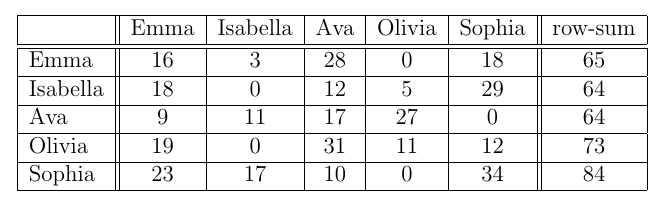

In [2]:
from IPython.display import Image
Image(filename='Data/Data-table.png')

The aim of our visualization is to illustrate the total number of posts by each community member, and the 
flows of posts between pairs of friends.

In [61]:
import platform, plotly
import numpy as np
from numpy import pi

In [6]:
print(f'Python version: {platform.python_version()}')
print(f'Plotly version: {plotly.__version__}')

Python version: 3.7.3
Plotly version: 4.5.4


Define the array of data:

In [7]:
matrix = np.array([[16,  3, 28,  0, 18],
                   [18,  0, 12,  5, 29],
                   [ 9, 11, 17, 27,  0],  
                   [19,  0, 31, 11, 12],
                   [23, 17, 10,  0, 34]], dtype=int)

In [8]:
def check_data(data_matrix):
    L, M = data_matrix.shape
    if L != M:
        raise ValueError('Data array must have a (n,n) shape')
    return L

In [9]:
L = check_data(matrix)

 A chord diagram encodes information in two graphical objects:
  - ideograms, represented by   distinctly colored arcs of circles;
  - ribbons, that are planar shapes bounded by two quadratic Bezier curves and two arcs of circle, that can degenerate to a point;

### Ideograms ###

Summing up the entries on each matrix row, one gets a value (in our example this value is equal to the number of posts by a community member).
Let us denote by `total_comments` the total number of posts recorded in this community.

Theoretically the interval `[0, total_comments)` is mapped linearly onto the unit circle, identified with the interval $[0,2\pi)$. 

For a better looking plot one proceeds as follows: starting from the angular position $0$, in counter-clockwise direction, one draws succesively, around the unit circle,  two parallel arcs of length equal to a mapped row sum value, minus a fixed gap. Click the image below:



In [13]:
from IPython.display import IFrame

In [23]:
IFrame('https://plot.ly/~empet/12234/', width=377, height=420)

Now we are defining  functions that process  data in order to get the ideogram ends.

As we pointed out, the unit circle is oriented counter-clockwise.
In order to get  an arc of circle of  end angular
coordinates $\theta_0<\theta_1$, we define the function, `moduloAB`, that resolves the case when an arc contains
the  point of angular coordinate $0$ (for example $\theta_0=2\pi-\pi/12$, $\theta_1=\pi/9$). The function corresponding to $a=-\pi, b=\pi$  allows to map the interval $[0,2\pi)$ onto $[-\pi, \pi)$. Via this transformation we have:

$\theta_0\mapsto \theta'_0=-\pi/12$, and 

$ \theta_1=\mapsto \theta'_1=\pi/9$,

and now $\theta'_0<\theta'_1$.

In [24]:
def moduloAB(x, a, b): #maps a real number onto the unit circle identified with 
                       #the interval [a,b), b-a=2*PI
        if a>= b:
            raise ValueError('Incorrect interval ends')
        y = (x-a) % (b-a)
        return y+b if y < 0 else y+a

In [25]:
def test_2PI(x):
     return 0 <= x < 2*pi

Compute the row sums and the lengths of corresponding ideograms:

In [26]:
row_sum = [matrix[k,:].sum() for k in range(L)]

#set the gap between two consecutive ideograms
gap = 2*pi*0.005
ideogram_length = 2*pi * np.asarray(row_sum) / sum(row_sum) - gap*np.ones(L)

The next function returns the list of  end angular coordinates for each ideogram arc:

In [27]:
def get_ideogram_ends(ideogram_len, gap):
    ideo_ends = []
    left = 0
    for k in range(len(ideogram_len)):
        right = left + ideogram_len[k]
        ideo_ends.append([left, right])   
        left = right + gap
    return ideo_ends 

In [28]:
ideo_ends = get_ideogram_ends(ideogram_length, gap)

The function `make_ideogram_arc` returns equally spaced points on an ideogram arc, expressed as complex
numbers in polar form:

In [29]:
def make_ideogram_arc(R, phi, a=50):
    # R is the circle radius
    # phi is the list of  angle coordinates of an arc ends
    # a is a parameter that controls the number of points to be evaluated on an arc
    if not test_2PI(phi[0]) or not test_2PI(phi[1]):
        phi = [moduloAB(t, 0, 2*pi) for t in phi]
    length = (phi[1]-phi[0]) % 2*pi 
    nr = 5 if length <= pi/4 else int(a*length/pi)

    if phi[0] < phi[1]:   
        theta = np.linspace(phi[0], phi[1], nr)
    else:
        phi = [moduloAB(t, -pi, pi) for t in phi]
        theta = np.linspace(phi[0], phi[1], nr)
    return R * np.exp(1j*theta)   

The real and imaginary parts of these complex numbers will be used to define the ideogram as a [Plotly
shape](https://plot.ly/python/shapes/) bounded by a SVG path.

In [30]:
make_ideogram_arc(1.3, [11*pi/6, pi/17])

array([1.12583302-0.65j      , 1.14814501-0.60972373j,
       1.16901672-0.5686826j , 1.18842197-0.5269281j ,
       1.20633642-0.48451259j, 1.22273759-0.44148929j,
       1.23760491-0.39791217j, 1.25091973-0.3538359j ,
       1.26266534-0.30931575j, 1.27282702-0.26440759j,
       1.28139202-0.21916775j, 1.28834958-0.17365297j,
       1.29369099-0.12792036j, 1.29740954-0.08202728j,
       1.29950058-0.0360313j , 1.29996146+0.01000988j,
       1.29879163+0.0560385j , 1.29599253+0.10199682j,
       1.2915677 +0.1478272j , 1.28552267+0.19347214j,
       1.27786503+0.23887437j])

Set ideograms labels and colors:

In [31]:
labels=['Emma', 'Isabella', 'Ava', 'Olivia', 'Sophia']
ideo_colors=['rgba(244, 109, 67, 0.75)',
             'rgba(253, 174, 97, 0.75)',
             'rgba(254, 224, 139, 0.75)',
             'rgba(217, 239, 139, 0.75)',
             'rgba(166, 217, 106, 0.75)']#brewer colors with alpha set on 0.75

### Ribbons in a chord diagram ###

While ideograms illustrate how many comments posted each member of the Facebook community,  ribbons
give a comparative information on the flows of comments from one friend to another.

To illustrate this flow we map data onto the unit circle. More precisely, for each matrix row, $k$, the application:

`t`$\mapsto$ `t*ideogram_length[k]/row_sum[k]`

maps the interval `[0, row_sum[k]]` onto
the interval `[0, ideogram_length[k]]. Hence each entry `matrix[k][j]` in the $k^{th}$  row is mapped to `matrix[k][j] * ideogram_length[k] / row_value[k]`.

The function `map_data` maps all matrix entries to the corresponding values in the intervals associated to ideograms:

In [32]:
def map_data(data_matrix, row_value, ideogram_length):
    mapped = np.zeros(data_matrix.shape)
    for j  in range(L):
        mapped[:, j] = ideogram_length * data_matrix[:,j] / row_value
    return mapped  

In [33]:
mapped_data = map_data(matrix, row_sum, ideogram_length)
mapped_data

array([[0.27949818, 0.05240591, 0.48912181, 0.        , 0.31443545],
       [0.31429952, 0.        , 0.20953301, 0.08730542, 0.50637144],
       [0.15714976, 0.19207193, 0.29683843, 0.47144927, 0.        ],
       [0.33291045, 0.        , 0.54316969, 0.19273763, 0.21025923],
       [0.40429305, 0.2988253 , 0.17577959, 0.        , 0.5976506 ]])

- To each pair of values `(mapped_data[k][j], mapped_data[j][k])`, $k<=j$,  one associates a ribbon, that is a curvilinear filled rectangle (that can be degenerate), having as opposite sides two subarcs of the $k^{th}$ ideogram, respectively $j^{th}$ ideogram, and two arcs of quadratic B&eacute;zier curves.

Here we illustrate the ribbons associated to pairs `(mapped_data[0][j], mapped_data[j][0])`, $j=\overline{0,4}$,
that illustrate the flow of comments between Emma and all other friends, and  herself:

In [35]:
IFrame('https://plot.ly/~empet/12519/', width=420, height=420)

- For a better looking chord diagram, 
[Circos documentation](http://circos.ca/presentations/articles/vis_tables1/) recommends to sort increasingly each row of the mapped_data. 

The  array `idx_sort`, defined below, has on each row the indices that sort the corresponding row in `mapped_data`:

In [36]:
idx_sort = np.argsort(mapped_data, axis=1)
idx_sort

array([[3, 1, 0, 4, 2],
       [1, 3, 2, 0, 4],
       [4, 0, 1, 2, 3],
       [1, 3, 4, 0, 2],
       [3, 2, 1, 0, 4]], dtype=int64)

In the following we call ribbon ends, the lists `l=[l[0], l[1]]`, `r=[r[0], r[1]]` having as elements the angular coordinates
of the ends of arcs that are opposite sides in a ribbon. These arcs are sub-arcs in the internal boundaries of
the ideograms, connected by the ribbon
(see the image above).

- Compute the ribbon ends  and store them as tuples 
in a list of lists ($L\times L$):

In [37]:
def make_ribbon_ends(mapped_data, ideo_ends,  idx_sort):
    L = mapped_data.shape[0]
    ribbon_boundary = np.zeros((L,L+1))
    for k in range(L):
        start = ideo_ends[k][0]
        ribbon_boundary[k][0] = start
        for j in range(1,L+1):
            J = idx_sort[k][j-1]
            ribbon_boundary[k][j] = start + mapped_data[k][J]
            start = ribbon_boundary[k][j]
    return [[(ribbon_boundary[k][j], ribbon_boundary[k][j+1] ) for j in range(L)] for k in range(L)]   

In [38]:
ribbon_ends = make_ribbon_ends(mapped_data, ideo_ends,  idx_sort)
print ('ribbon ends starting from the ideogram[2]\n', ribbon_ends[2])

ribbon ends starting from the ideogram[2]
 [(2.31580258464619, 2.31580258464619), (2.31580258464619, 2.472952342161697), (2.472952342161697, 2.6650242680139837), (2.6650242680139837, 2.9618626988766086), (2.9618626988766086, 3.43331197142313)]


We note that `ribbon_ends[k][j]` corresponds to `mapped_data[i][idx_sort[k][j]]`, i.e. the length of the arc of ends in `ribbon_ends[k][j]` is equal to `mapped_data[i][idx_sort[k][j]]`.

Now we define a few functions that compute the  control points for B&eacute;zier ribbon sides.

The function `control_pts` returns the cartesian coordinates of  the  control points, $b_0, b_1, b_2$, supposed as being  initially located on the unit circle, and thus defined only by their angular coordinate.  The angular coordinate
of the point $b_1$ is the mean of angular coordinates of the points $b_0, b_2$.

Since for a  B&eacute;zier ribbon side only $b_0, b_2$ are placed on the unit circle, one gives `radius` as a parameter that controls position of $b_1$.  `radius` is the distance  of $b_1$ to the circle center.

In [39]:
def control_pts(angle, radius):
    #angle is a  3-list containing angular coordinates of the control points b0, b1, b2
    #radius is the distance from b1 to the  origin O(0,0) 

    if len(angle) != 3:
        raise InvalidInputError('angle must have len =3')
    b_cplx = np.array([np.exp(1j*angle[k]) for k in range(3)])
    b_cplx[1] = radius * b_cplx[1]
    return list(zip(b_cplx.real, b_cplx.imag))

In [40]:
def ctrl_rib_chords(l, r, radius):
    # this function returns a 2-list containing control poligons of the two quadratic Bezier
    #curves that are opposite sides in a ribbon
    #l (r) the list of angular variables of the ribbon arc ends defining 
    #the ribbon starting (ending) arc 
    # radius is a common parameter for both control polygons
    if len(l) != 2 or len(r) != 2:
        raise ValueError('the arc ends must be elements in a list of len 2')
    return [control_pts([l[j], (l[j]+r[j])/2, r[j]], radius) for j in range(2)]

Each ribbon is colored with the color of one of the two  ideograms it connects. 
We define an L-list of L-lists of colors for ribbons. Denote it by `ribbon_color`.

`ribbon_color[k][j]` is the Plotly color string for the ribbon associated to `mapped_data[k][j]` and `mapped_data[j][k]`, i.e. the ribbon connecting two subarcs in the $k^{th}$, respectively, $j^{th}$ ideogram. Hence  this structure is symmetric.

Initially we define:

In [41]:
ribbon_color = [L * [ideo_colors[k]] for k in range(L)]

and then eventually we are changing  the color in a few positions.

For our example we are perfotming the following color change:

In [42]:
ribbon_color[0][4]=ideo_colors[4]
ribbon_color[1][2]=ideo_colors[2]
ribbon_color[2][3]=ideo_colors[3]
ribbon_color[2][4]=ideo_colors[4]

The symmetric locations are not modified, because  we do not access 
`ribbon_color[k][j]`, $k>j$, when drawing the ribbons.

Functions that return the Plotly SVG paths that are  ribbon boundaries:

In [43]:
def make_q_bezier(b):# defines the Plotly SVG path for a quadratic Bezier curve defined by the 
                     #list of its control points
    if len(b) != 3:
        raise valueError('control poligon must have 3 points')
    A, B, C = b    
    return f'M {A[0]}, {A[1]} Q {B[0]}, {B[1]} {C[0]}, {C[1]}'

In [44]:
b=[(1,4), (-0.5, 2.35), (3.745, 1.47)]

In [45]:
make_q_bezier(b)

'M 1, 4 Q -0.5, 2.35 3.745, 1.47'

`make_ribbon_arc`  returns the Plotly SVG path corresponding to an arc represented by its end angular coordinates, `theta0, theta1`.

In [46]:
def make_ribbon_arc(theta0, theta1):

    if test_2PI(theta0) and test_2PI(theta1):
        if theta0 < theta1:
            theta0 = moduloAB(theta0, -pi, pi)
            theta1 = moduloAB(theta1, -pi, pi)
            if theta0  *theta1 > 0:
                raise ValueError('incorrect angle coordinates for ribbon')
    
        nr = int(40 * (theta0 - theta1) / pi)
        if nr <= 2: nr = 3
        theta = np.linspace(theta0, theta1, nr)
        pts=np.exp(1j*theta)# points in polar complex form, on the given arc
    
        string_arc = ''
        for k in range(len(theta)):
            string_arc += f'L {pts.real[k]}, {pts.imag[k]} '
        return   string_arc 
    else:
        raise ValueError('the angle coordinates for an arc side of a ribbon must be in [0, 2*pi]')

In [47]:
make_ribbon_arc(np.pi/3, np.pi/6)

'L 0.5000000000000001, 0.8660254037844386 L 0.5877852522924732, 0.8090169943749473 L 0.6691306063588582, 0.7431448254773941 L 0.7431448254773944, 0.6691306063588581 L 0.8090169943749475, 0.5877852522924731 L 0.8660254037844387, 0.49999999999999994 '

Finally we are ready to define data and layout for the Plotly plot of the chord diagram.

In [48]:
import plotly.graph_objects as go

In [49]:
def plot_layout(title, plot_size):

    return dict(title=title,
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                showlegend=False,
                width=plot_size,
                height=plot_size,
                margin=dict(t=25, b=25, l=25, r=25),
                hovermode='closest',
                 )  

Function that returns the Plotly shape of an ideogram:

In [50]:
def make_ideo_shape(path, line_color, fill_color):
    #line_color is the color of the shape boundary
    #fill_collor is the color assigned to an ideogram
    
    return  dict(line=dict(color=line_color, 
                           width=0.45),
                 path=path,
                 layer='below',
                 type='path',
                 fillcolor=fill_color)   

We generate two types of ribbons: a ribbon connecting subarcs in two distinct ideograms, respectively
a ribbon from one ideogram to itself (it corresponds to `mapped_data[k][k]`, i.e. it gives the flow of comments
from a community member to herself).

In [51]:
def make_ribbon(l, r, line_color, fill_color, radius=0.2):
    #l=[l[0], l[1]], r=[r[0], r[1]]  represent the opposite arcs in the ribbon 
    #line_color is the color of the shape boundary
    #fill_color is the fill color for the ribbon shape
    
    poligon = ctrl_rib_chords(l,r, radius)
    b, c = poligon  
           
    return  dict(line=dict(color=line_color, 
                             width=0.5),
                 path=make_q_bezier(b) + make_ribbon_arc(r[0], r[1])+
                         make_q_bezier(c[::-1]) + make_ribbon_arc(l[1], l[0]),
                 type='path',
                 layer='below',
                 fillcolor = fill_color,    
        )

def make_self_rel(l, line_color, fill_color, radius):
    #radius is the radius of Bezier control point b_1
    
    b = control_pts([l[0], (l[0]+l[1])/2, l[1]], radius) 
    
    return  dict(line = dict(color=line_color, 
                             width=0.5),
                 path =  make_q_bezier(b)+make_ribbon_arc(l[1], l[0]),
                 type = 'path',
                 layer = 'below',
                 fillcolor = fill_color   
                )

In [52]:
def invPerm(perm):
    # function that returns the inverse of a permutation, perm
    inv = [0] * len(perm)
    for i, s in enumerate(perm):
        inv[s] = i
    return inv

In [53]:
layout=plot_layout('Chord diagram', 400)    

Now let us explain the key point of associating  ribbons  to right data:
    
From the definition of `ribbon_ends` we notice that `ribbon_ends[k][j]` corresponds to data stored in
`matrix[k][sigma[j]]`, where `sigma` is the permutation of indices $0, 1, \ldots L-1$, that sort the row k in `mapped_data`.
If `sigma_inv` is the inverse permutation of `sigma`, we get that to `matrix[k][j]` corresponds the
`ribbon_ends[k][sigma_inv[j]]`.

`ribbon_info` is a list of dicts setting the information that is displayed when hovering the mouse over the  ribbon ends.

Set the radius of B&eacute;zier control point, $b_1$, for each ribbon associated to a diagonal data entry:

In [54]:
radii_sribb = [0.4, 0.30, 0.35, 0.39, 0.12]# these value are set after a few trials 

In [55]:
ribbon_info = []
shapes = []
for k in range(L):
    
    sigma = idx_sort[k]
    sigma_inv = invPerm(sigma)
    for j in range(k, L):
        if matrix[k][j] == 0 and matrix[j][k]==0: continue
        eta = idx_sort[j]
        eta_inv = invPerm(eta)
        l = ribbon_ends[k][sigma_inv[j]]  
        
        if j == k:
            shapes.append(make_self_rel(l, 'rgb(175,175,175)' ,
                                    ideo_colors[k], radius=radii_sribb[k])) 
            z = 0.9*np.exp(1j*(l[0]+l[1])/2)
            
            #the text below will be displayed when hovering the mouse over the ribbon
            text = f'{labels[k]} commented on {int(matrix[k][k])} of herself Fb posts'

            ribbon_info.append(go.Scatter(x=[z.real],
                                       y=[z.imag],
                                       mode='markers',
                                       marker=dict(size=0.5, color=ideo_colors[k]),
                                       text=text,
                                       hoverinfo='text'
                                       )
                              )
        else:
            r = ribbon_ends[j][eta_inv[k]]
            zi = 0.9 * np.exp(1j*(l[0]+l[1])/2)
            zf = 0.9 * np.exp(1j*(r[0]+r[1])/2)
            #texti and textf are the strings that will be displayed when hovering the mouse 
            #over the two ribbon ends
            texti = f'{labels[k]} commented on {int(matrix[k][j])} of {labels[j]} Fb posts'
            textf = f'{labels[j]} commented on {int(matrix[j][k])} of {labels[k]} Fb posts'
            
            ribbon_info.append(go.Scatter(x=[zi.real],
                                          y=[zi.imag],
                                          mode='markers',
                                          marker=dict(size=0.5, color=ribbon_color[k][j]),
                                          text=texti,
                                          hoverinfo='text'
                                       )
                              ),
            ribbon_info.append(go.Scatter(x=[zf.real],
                                          y=[zf.imag],
                                          mode='markers',
                                          marker=dict(size=0.5, color=ribbon_color[k][j]),
                                          text=textf,
                                          hoverinfo='text'
                                       )
                              )
            r = (r[1], r[0]) # IMPORTANT!!!  Reverse these arc ends because otherwise you get
                          # a twisted ribbon
            #append the ribbon shape
            shapes.append(make_ribbon(l, r, 'rgb(175,175,175)' , ribbon_color[k][j]))
           
                                    
            

`ideograms` is a list of dicts that set the position, and color of ideograms, as well as the information associated to each ideogram.


In [56]:
ideograms = []
for k in range(len(ideo_ends)):
    z =  make_ideogram_arc(1.1, ideo_ends[k])
    zi = make_ideogram_arc(1.0, ideo_ends[k])
    m = len(z)
    n = len(zi)
    ideograms.append(go.Scatter(x=z.real,
                                y=z.imag,
                                mode='lines',
                                line=dict(color=ideo_colors[k], shape='spline', width=0.25),
                                text=f'{labels[k]} <br>{int(row_sum[k])} comments', 
                                hoverinfo='text'
                             )
                     )
    
       
    path = 'M '
    for s in range(m):
        path += f'{z.real[s]}, {z.imag[s]} L '
        
    Zi = np.array(zi.tolist()[::-1]) 

    for s in range(m):
        path += f'{Zi.real[s]}, {Zi.imag[s]} L '
    path += f'{z.real[0]} ,{z.imag[0]}' 
   
    shapes.append(make_ideo_shape(path,'rgb(150,150,150)' , ideo_colors[k]))
    

In [57]:
data = ideograms + ribbon_info
layout['shapes'] = shapes
fig = go.Figure(data=data, layout=layout)
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
init_notebook_mode(connected=True)
iplot(fig)

Here is a chord diagram associated to a community of 8 Facebook friends:

In [58]:
IFrame('https://plot.ly/~empet/12148/chord-diagram-of-facebook-comments-in-a-community/',
     width=500, height=500)

In [60]:
from IPython.core.display import HTML
def  css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()